#### Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical

#### Setting the dataset path


In [2]:
#read DataSet
TrainImage="./Dataset/"

print(TrainImage)

./Dataset/


In [3]:
#to get all image names in train file
Noncovidimages = os.listdir(TrainImage + "/NONCOVID")
COVID19images = os.listdir(TrainImage + "/COVID19")

#### Explore the Data

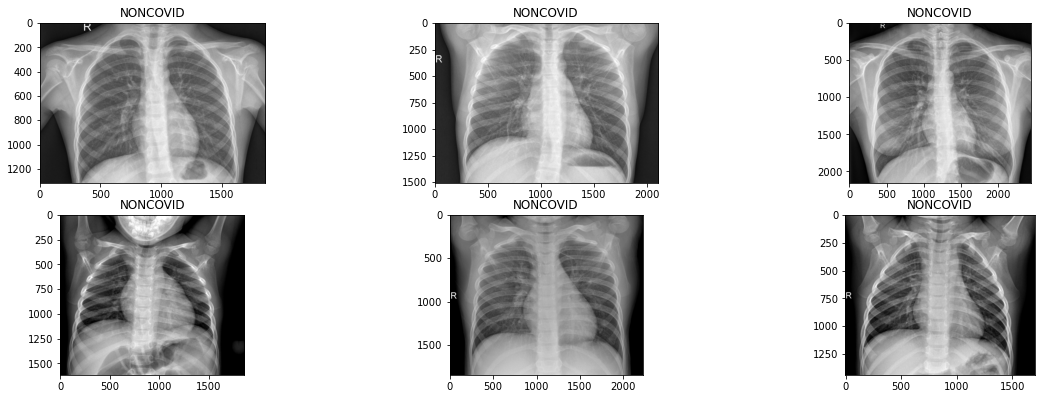

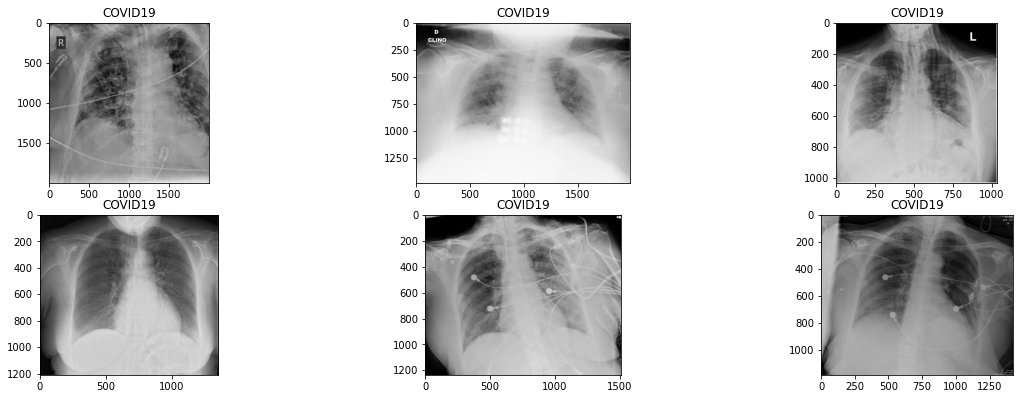

In [4]:
plt.show()
#plot NONCOVID
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NONCOVID",Noncovidimages[i])),cmap='gray')
    plt.title("NONCOVID")

plt.show()
#plot COVID
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

#### ImageDataGenerator (DataAugmentation )

In [6]:
Labels={'COVID19':0,'NONCOVID':1 }

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
               
#Test        
print(getCode('COVID19'))
print(getLabel(1))

0
NONCOVID


#### Load Data

In [8]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [9]:
#get train data
X_train, y_train = getData(TrainImage,sizeImage)

In [10]:
print("X_train Shape        ",X_train.shape)

X_train Shape         (6432, 300, 300, 3)


In [11]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)

y_train  (6432, 3)


In [12]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

## Build Model

In [13]:
#load weight
Network_Weight="./DenseNet-BC-121-32-no-top.h5"
print(Network_Weight)

./DenseNet-BC-121-32-no-top.h5


In [14]:
from tensorflow.keras.applications.densenet import DenseNet121
pre_trained_model = DenseNet121(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights


In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
from keras import backend as K

def f1_score(X_train, y_train):
    def recall(X_train, y_train):
        true_positives = K.sum(K.round(K.clip(X_train * y_train, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(X_train, y_train):
        true_positives = K.sum(K.round(K.clip(X_train * y_train, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(X_train, y_train)
    recall = recall(X_train, y_train)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)   

model = Model( pre_trained_model.input, x) 

model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='Sensitivity'), 
                       tf.keras.metrics.SpecificityAtSensitivity(0.5, name='Specificity'), f1_score, 
                       tf.keras.metrics.TruePositives(name='tp'), tf.keras.metrics.TrueNegatives(name='tn'), 
                       tf.keras.metrics.FalseNegatives(name='fn'), tf.keras.metrics.FalsePositives(name='fp')])

#### K-fold Cross Validation

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from sklearn.model_selection import KFold

# K-fold Cross Validation model evaluation
num_folds = 5
fold_no = 1
epochs = 10
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)


In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

C:\Users\supriti.ghosh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
20/20 [==============================] - 381s 19s/step - loss: 2.2483 - accuracy: 0.8855 - auc: 0.9145 - precision: 0.8543 - Sensitivity: 0.8536 - Specificity: 0.9441 - f1_score: 0.8376 - tp: 2262.0476 - tn: 4817.0952 - fn: 310.7619 - fp: 328.5238
Epoch 2/10
20/20 [==============================] - 369s 18s/step - loss: 0.1115 - accuracy: 0.9794 - auc: 0.9912 - precision: 0.9670 - Sensitivity: 0.9781 - Specificity: 0.9926 - f1_score: 0.9672 - tp: 2721.5714 - tn: 5481.1905 - fn: 60.2381 - fp: 82.4286
Epoch 3/10
20/20 [==============================] - 367s 19s/step - loss: 0.0485 - accuracy: 0.9907 - auc: 0.9964 - precision: 0.9855 - Sensitivity: 0.9873 - Specificity: 0.9980 - f1_score: 0.9873 - tp: 2540.9048 - tn: 5106.8095 - fn: 31.9048 - fp: 38.8095
Epoch 4/10
20/20 [==============================] - 368s 19s/step - loss: 0.0290 - accuracy: 0.9912 - auc: 0.9981 - precision: 0.9890 - Sensitivity: 0.9896 - Specificity: 0.9987 - f1_score: 0.9903 - tp: 2542.5714 - tn: 5115.571

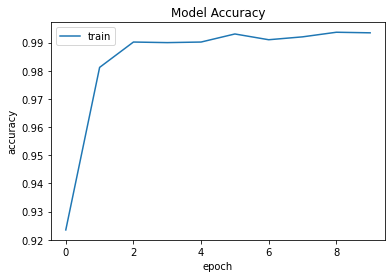

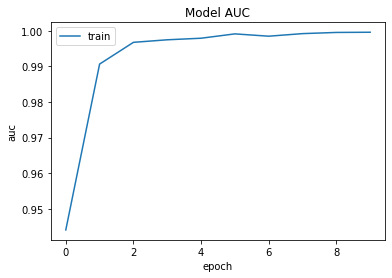

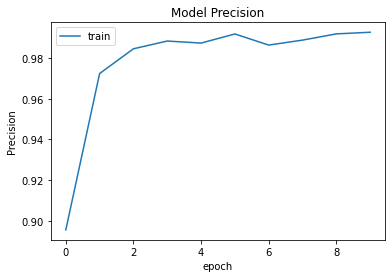

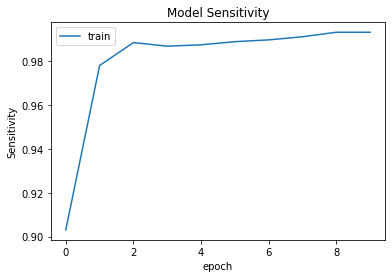

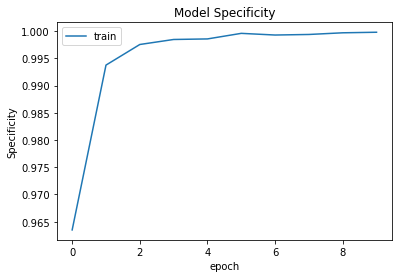

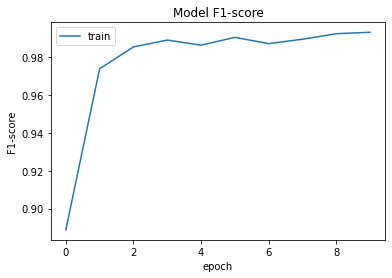

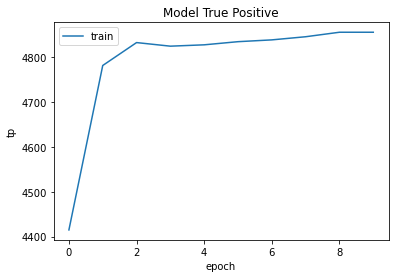

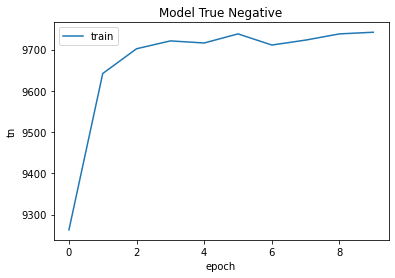

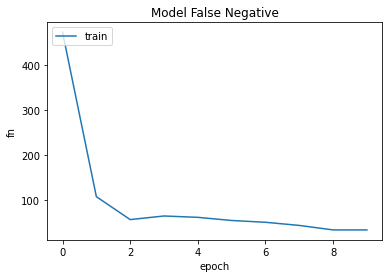

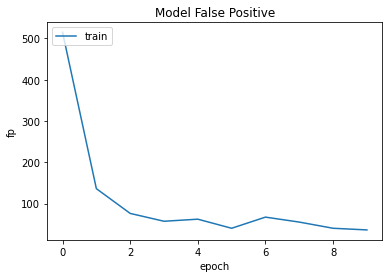

26/26 [==============================] - 101s 4s/step - loss: 0.0278 - accuracy: 0.9915 - auc: 0.9989 - precision: 0.9915 - Sensitivity: 0.9915 - Specificity: 0.9996 - f1_score: 0.9915 - tp: 1276.0000 - tn: 2563.0000 - fn: 11.0000 - fp: 11.0000
Score for fold 1: loss of 0.02775568701326847; accuracy of 99.14529919624329%; auc of 0.9989403486251831; precision of 0.9914529919624329; Sensitivity of 0.9914529919624329; Specificity of 0.999611496925354; f1_score of 0.9915383458137512; tp of 1276.0; tn of 2563.0; fn of 11.0
Epoch 1/10
20/20 [==============================] - 421s 20s/step - loss: 0.0213 - accuracy: 0.9930 - auc: 0.9991 - precision: 0.9918 - Sensitivity: 0.9943 - Specificity: 0.9996 - f1_score: 0.9922 - tp: 4861.0000 - tn: 9738.0000 - fn: 28.0000 - fp: 40.0000
Epoch 2/10
20/20 [==============================] - 379s 19s/step - loss: 0.0212 - accuracy: 0.9916 - auc: 0.9991 - precision: 0.9902 - Sensitivity: 0.9900 - Specificity: 0.9996 - f1_score: 0.9906 - tp: 4840.0000 - tn: 

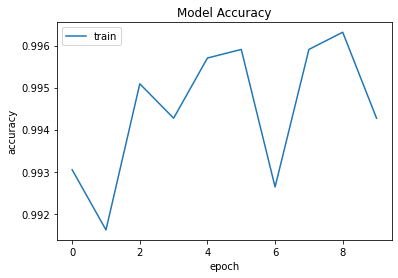

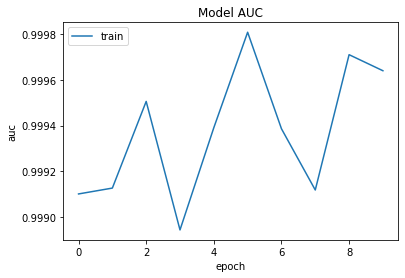

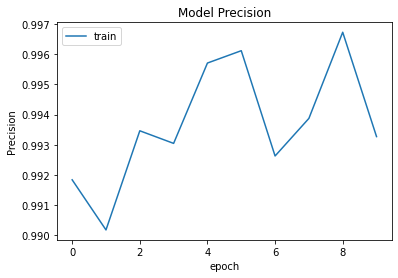

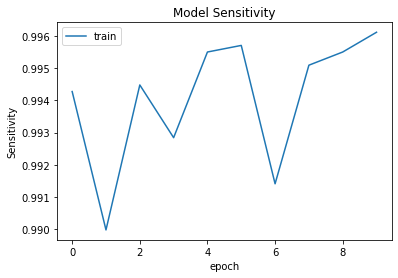

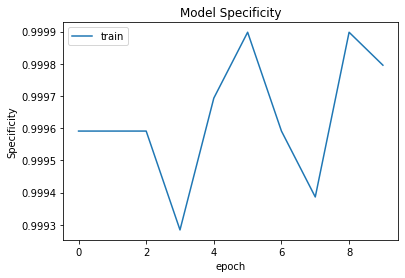

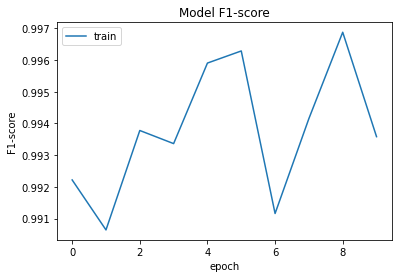

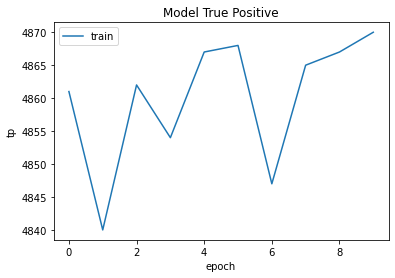

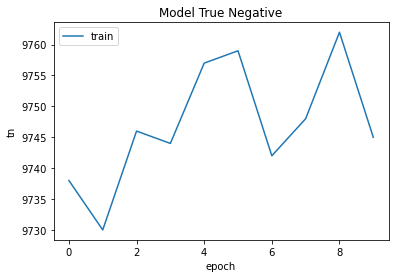

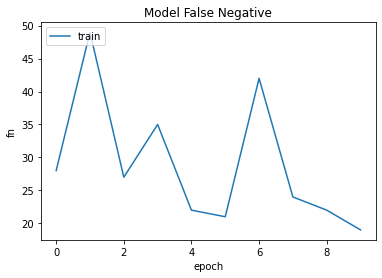

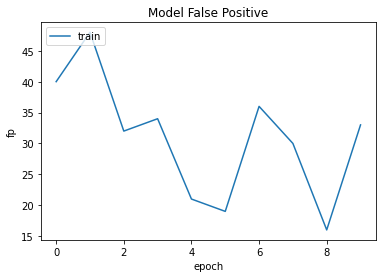

26/26 [==============================] - 100s 4s/step - loss: 0.0030 - accuracy: 0.9984 - auc: 1.0000 - precision: 0.9984 - Sensitivity: 0.9977 - Specificity: 1.0000 - f1_score: 0.9985 - tp: 1284.0000 - tn: 2572.0000 - fn: 3.0000 - fp: 2.0000
Score for fold 2: loss of 0.0029761011246591806; accuracy of 99.8445987701416%; auc of 0.9999943375587463; precision of 0.9984447956085205; Sensitivity of 0.997668981552124; Specificity of 1.0; f1_score of 0.9984614849090576; tp of 1284.0; tn of 2572.0; fn of 3.0
Epoch 1/10
20/20 [==============================] - 593s 24s/step - loss: 0.0108 - accuracy: 0.9953 - auc: 0.9995 - precision: 0.9943 - Sensitivity: 0.9955 - Specificity: 0.9997 - f1_score: 0.9928 - tp: 4868.0000 - tn: 9752.0000 - fn: 22.0000 - fp: 28.0000
Epoch 2/10
20/20 [==============================] - 382s 19s/step - loss: 0.0112 - accuracy: 0.9953 - auc: 0.9998 - precision: 0.9959 - Sensitivity: 0.9935 - Specificity: 0.9999 - f1_score: 0.9961 - tp: 4858.0000 - tn: 9760.0000 - fn: 3

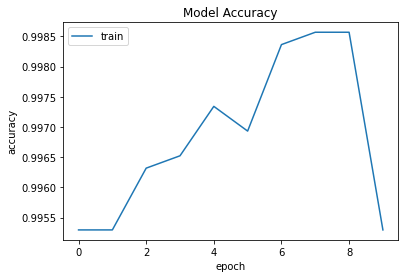

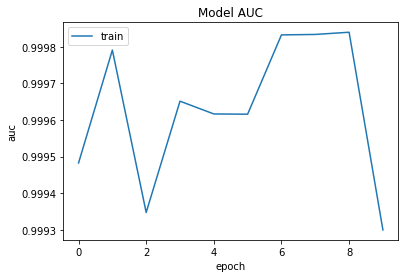

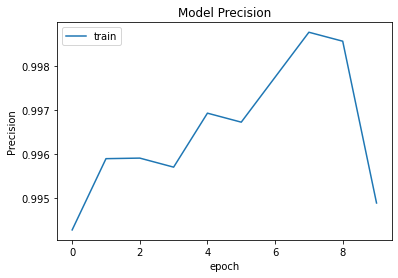

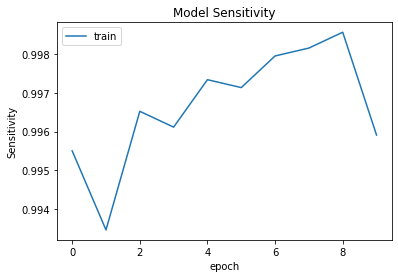

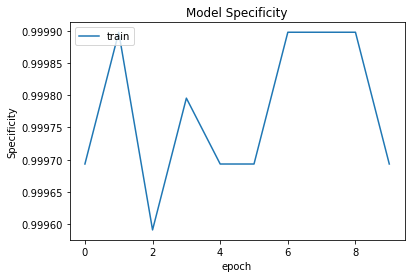

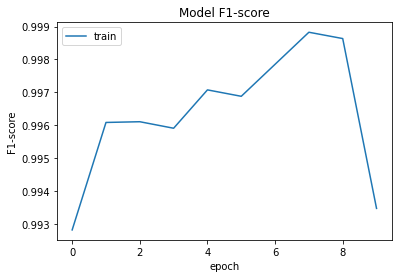

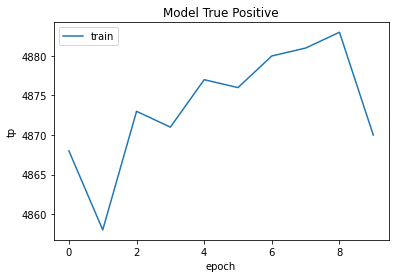

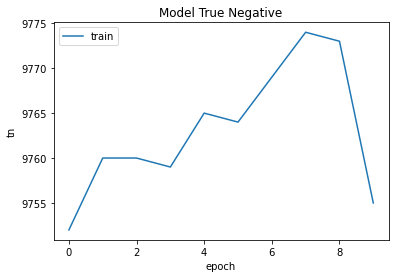

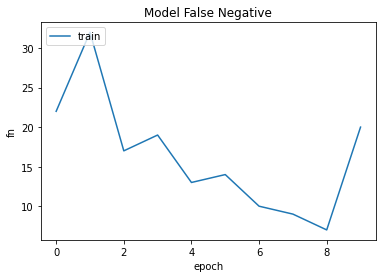

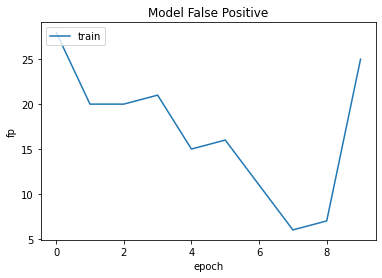

26/26 [==============================] - 106s 4s/step - loss: 0.0068 - accuracy: 0.9961 - auc: 1.0000 - precision: 0.9961 - Sensitivity: 0.9953 - Specificity: 1.0000 - f1_score: 0.9962 - tp: 1280.0000 - tn: 2567.0000 - fn: 6.0000 - fp: 5.0000
Score for fold 3: loss of 0.006772689521312714; accuracy of 99.61119890213013%; auc of 0.9999727606773376; precision of 0.9961089491844177; Sensitivity of 0.9953343868255615; Specificity of 1.0; f1_score of 0.9961537718772888; tp of 1280.0; tn of 2567.0; fn of 6.0
Epoch 1/10
20/20 [==============================] - 603s 25s/step - loss: 0.0101 - accuracy: 0.9969 - auc: 0.9994 - precision: 0.9965 - Sensitivity: 0.9959 - Specificity: 0.9997 - f1_score: 0.9965 - tp: 5099.0000 - tn: 10222.0000 - fn: 21.0000 - fp: 18.0000
Epoch 2/10
20/20 [==============================] - 404s 20s/step - loss: 0.0070 - accuracy: 0.9969 - auc: 0.9997 - precision: 0.9971 - Sensitivity: 0.9971 - Specificity: 0.9998 - f1_score: 0.9973 - tp: 4876.0000 - tn: 9766.0000 - fn:

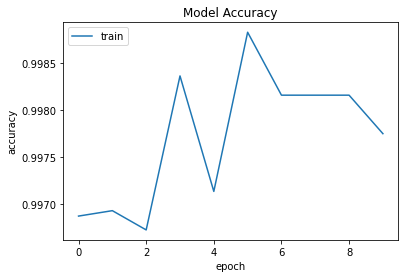

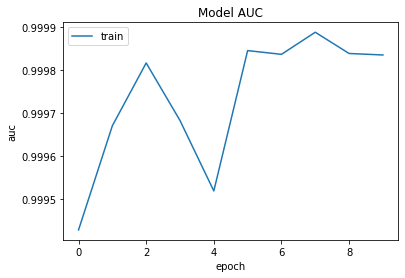

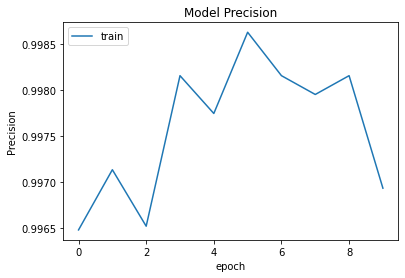

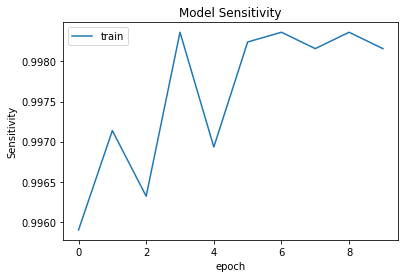

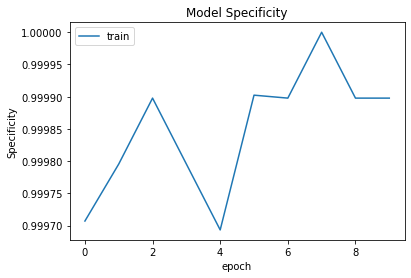

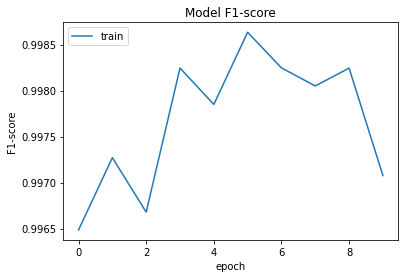

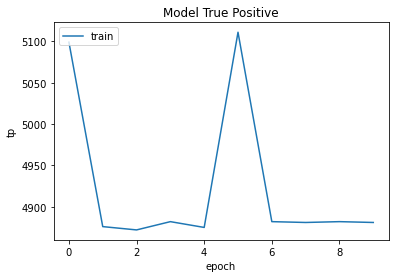

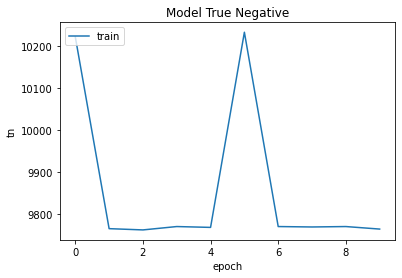

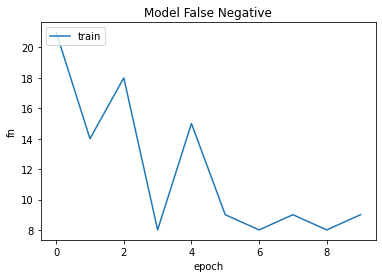

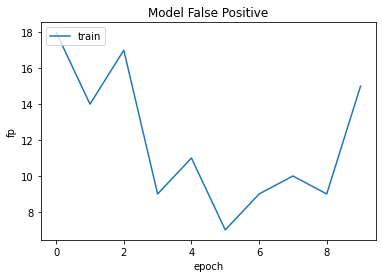

26/26 [==============================] - 101s 4s/step - loss: 0.0069 - accuracy: 0.9961 - auc: 1.0000 - precision: 0.9961 - Sensitivity: 0.9961 - Specificity: 1.0000 - f1_score: 0.9962 - tp: 1281.0000 - tn: 2567.0000 - fn: 5.0000 - fp: 5.0000
Score for fold 4: loss of 0.0068936822935938835; accuracy of 99.61119890213013%; auc of 0.9999758005142212; precision of 0.9961119890213013; Sensitivity of 0.9961119890213013; Specificity of 1.0; f1_score of 0.9961537718772888; tp of 1281.0; tn of 2567.0; fn of 5.0
Epoch 1/10
20/20 [==============================] - 525s 20s/step - loss: 0.0053 - accuracy: 0.9982 - auc: 0.9997 - precision: 0.9982 - Sensitivity: 0.9982 - Specificity: 0.9998 - f1_score: 0.9982 - tp: 4881.0000 - tn: 9771.0000 - fn: 9.0000 - fp: 9.0000
Epoch 2/10
20/20 [==============================] - 380s 19s/step - loss: 0.0058 - accuracy: 0.9975 - auc: 0.9998 - precision: 0.9975 - Sensitivity: 0.9971 - Specificity: 0.9999 - f1_score: 0.9977 - tp: 4876.0000 - tn: 9768.0000 - fn: 1

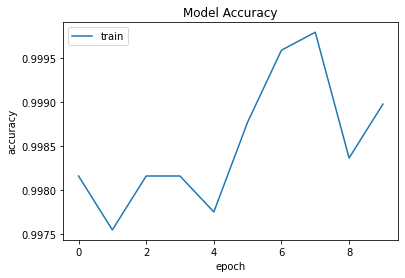

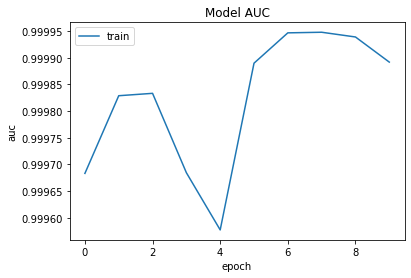

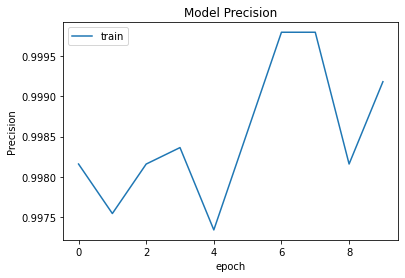

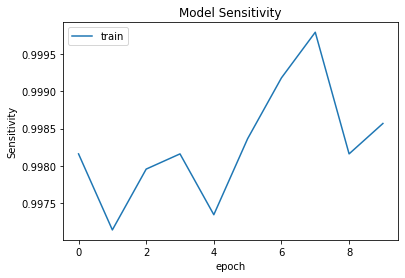

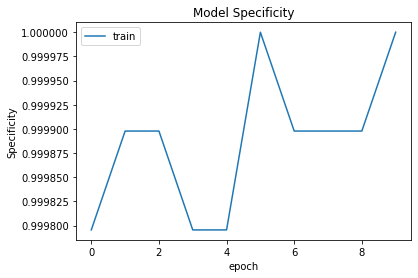

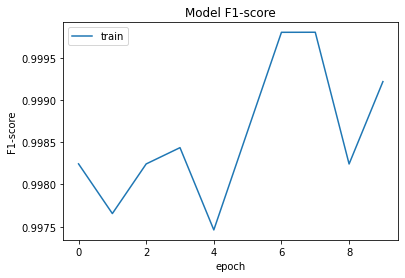

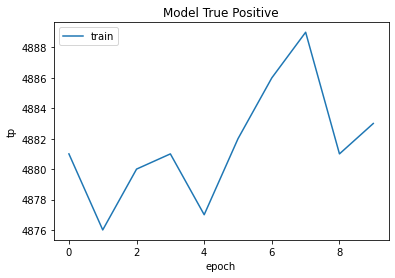

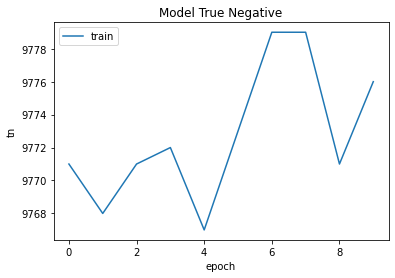

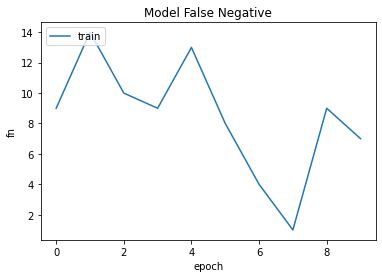

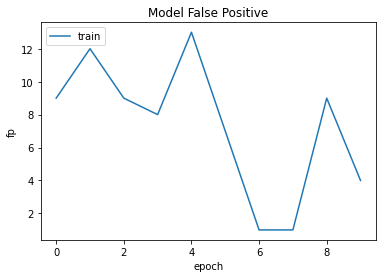

26/26 [==============================] - 102s 4s/step - loss: 0.0013 - accuracy: 0.9992 - auc: 1.0000 - precision: 1.0000 - Sensitivity: 0.9992 - Specificity: 1.0000 - f1_score: 1.0000 - tp: 1285.0000 - tn: 2572.0000 - fn: 1.0000 - fp: 0.0000e+00
Score for fold 5: loss of 0.0013347980566322803; accuracy of 99.92223978042603%; auc of 0.9999996423721313; precision of 1.0; Sensitivity of 0.9992223978042603; Specificity of 1.0; f1_score of 1.0; tp of 1285.0; tn of 2572.0; fn of 1.0


In [21]:
score_list = []

for train, test in kfold.split(X_train, y_train):
    
    train_generator =train_datagen.flow(
         X_train[train], y_train[train],
         batch_size= 256
    )

    test_generator =train_datagen.flow(
         X_train[test], y_train[test],
         batch_size= 50
    )  
    
    history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
             epochs=epochs)


    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['auc'])
    plt.title('Model AUC')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['Sensitivity'])
    plt.title('Model Sensitivity')
    plt.ylabel('Sensitivity')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['Specificity'])
    plt.title('Model Specificity')
    plt.ylabel('Specificity')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['f1_score'])
    plt.title('Model F1-score')
    plt.ylabel('F1-score')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['tp'])
    plt.title('Model True Positive')
    plt.ylabel('tp')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    #plt.savefig('tp.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.plot(history.history['tn'])
    plt.title('Model True Negative')
    plt.ylabel('tn')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['fn'])
    plt.title('Model False Negative')
    plt.ylabel('fn')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['fp'])
    plt.title('Model False Positive')
    plt.ylabel('fp')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    # Generate generalization metrics
    scores = model.evaluate(test_generator)
    score_list.append(scores)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}; {model.metrics_names[6]} of {scores[6]}; {model.metrics_names[7]} of {scores[7]}; {model.metrics_names[8]} of {scores[8]}; {model.metrics_names[9]} of {scores[9]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1
 

In [22]:
for s in score_list:
    print(s[1]*100)

99.14529919624329
99.8445987701416
99.61119890213013
99.61119890213013
99.92223978042603
